# Gesture Classification with Ensemble Methods

In [4]:
import os
import numpy as np
import matplotlib
matplotlib.use('TkAgg') # For displaying animation
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neural_network import MLPClassifier as mlpc
from sklearn import linear_model as lm
from sklearn import svm as svm
from helper_functions import *
from normalize_data import *
from numpy import array
from sklearn import preprocessing as pp
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

%matplotlib notebook

normalization function imported


## Load the Motion Data

Data is in x and y coordinates for each pixel. Each sample will be an array of 10 (frames) x 40 x 40 (capture window) x 2 (x and y) dimensions. 

## Load raw data for preprocessing

In [5]:
RAW_DATA_DIR = 'sonic_pi_face/data/'

# Get list of data files
data_files = get_data_files(RAW_DATA_DIR)

# Load data into a dictionary
# Note: Checks for incomplete data
data_dict = get_gesture_data(data_files)

## Visualize optical flow (Optional)

### Visualize individual frame (Optional)

In [6]:
gestures = list(data_dict)
print(gestures) # List gestures
sample = data_dict['open-close'][3] # 3rd Open-close sample
image = sample[4] # 5th frame of sample
# plt.imshow(image)
# plt.show()

['empty', 'waving-beauty-pageant-style', 'slide-horizontally', 'open-close', 'slide-vertically']


### Visualize horizontal motion across frames (Optional)

In [7]:
sample = data_dict['open-close'][5] # Fifth sample
# anim = display_frames(sample)

## Feature Engineering

Find features that increase the sample classification.

### WIP - Histogram of Gradients

<IPython.core.display.Javascript object>


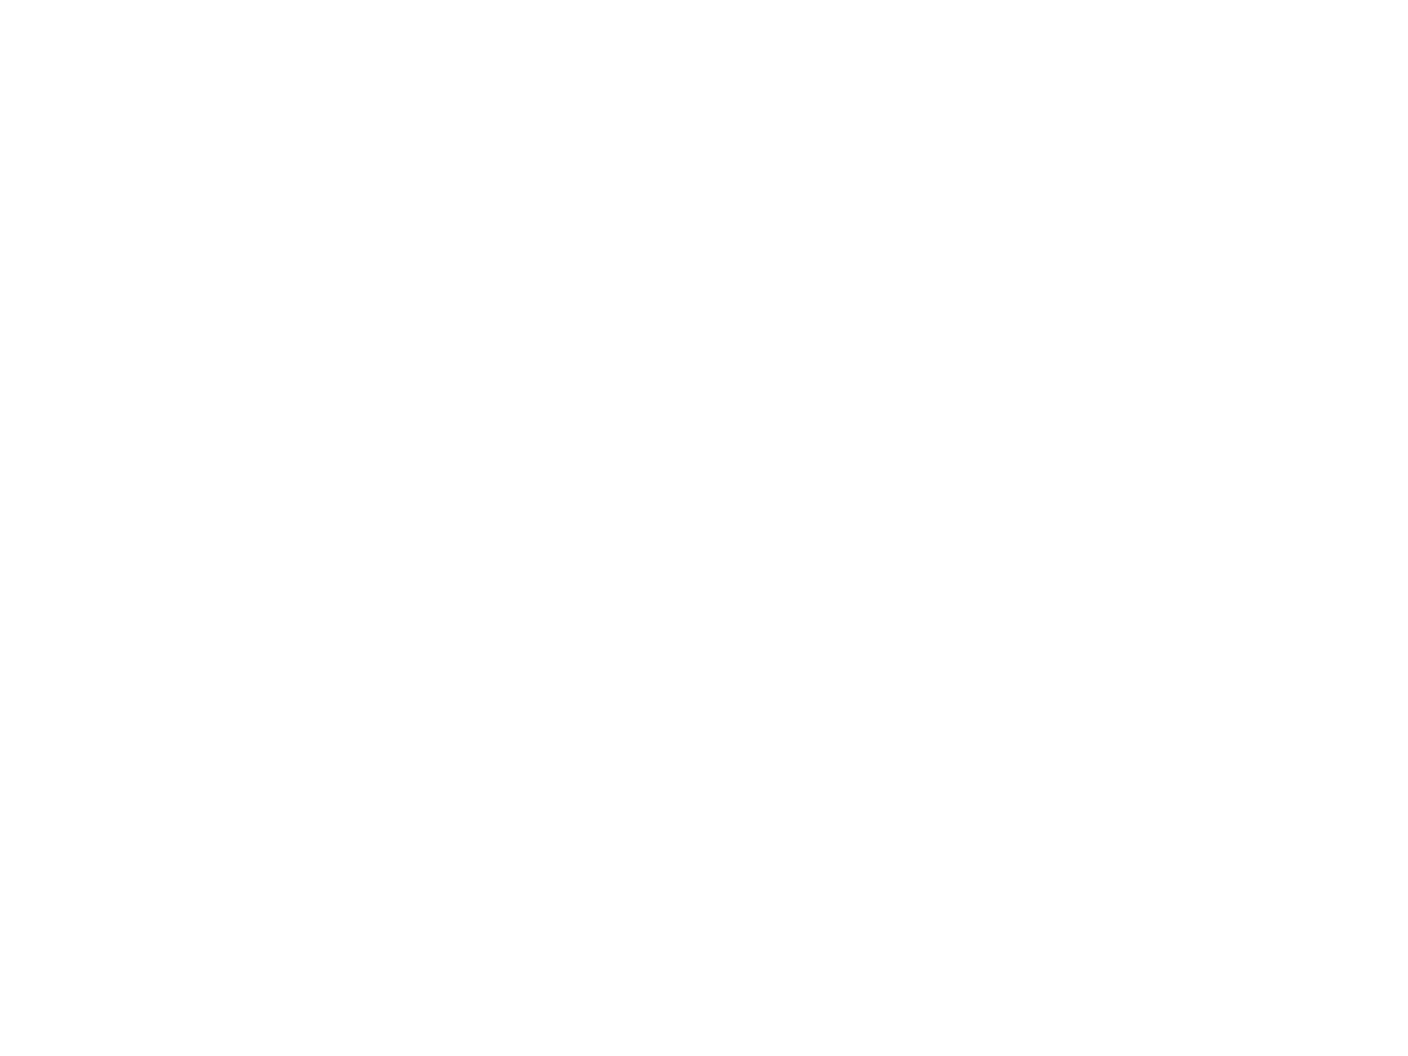

<IPython.core.display.Javascript object>


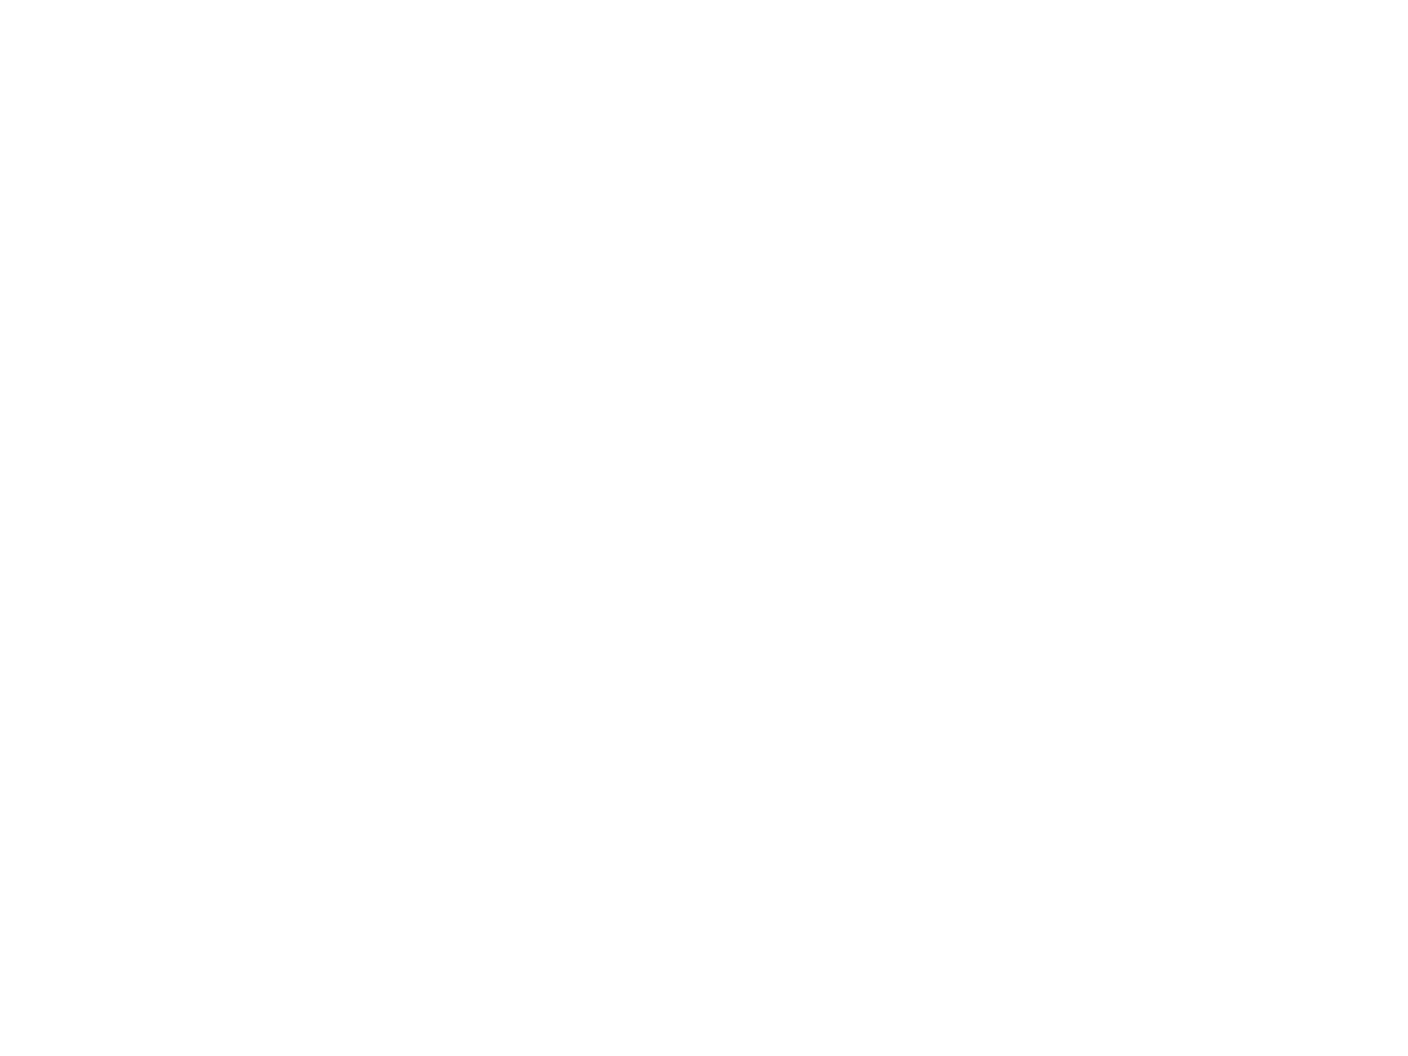

<IPython.core.display.Javascript object>


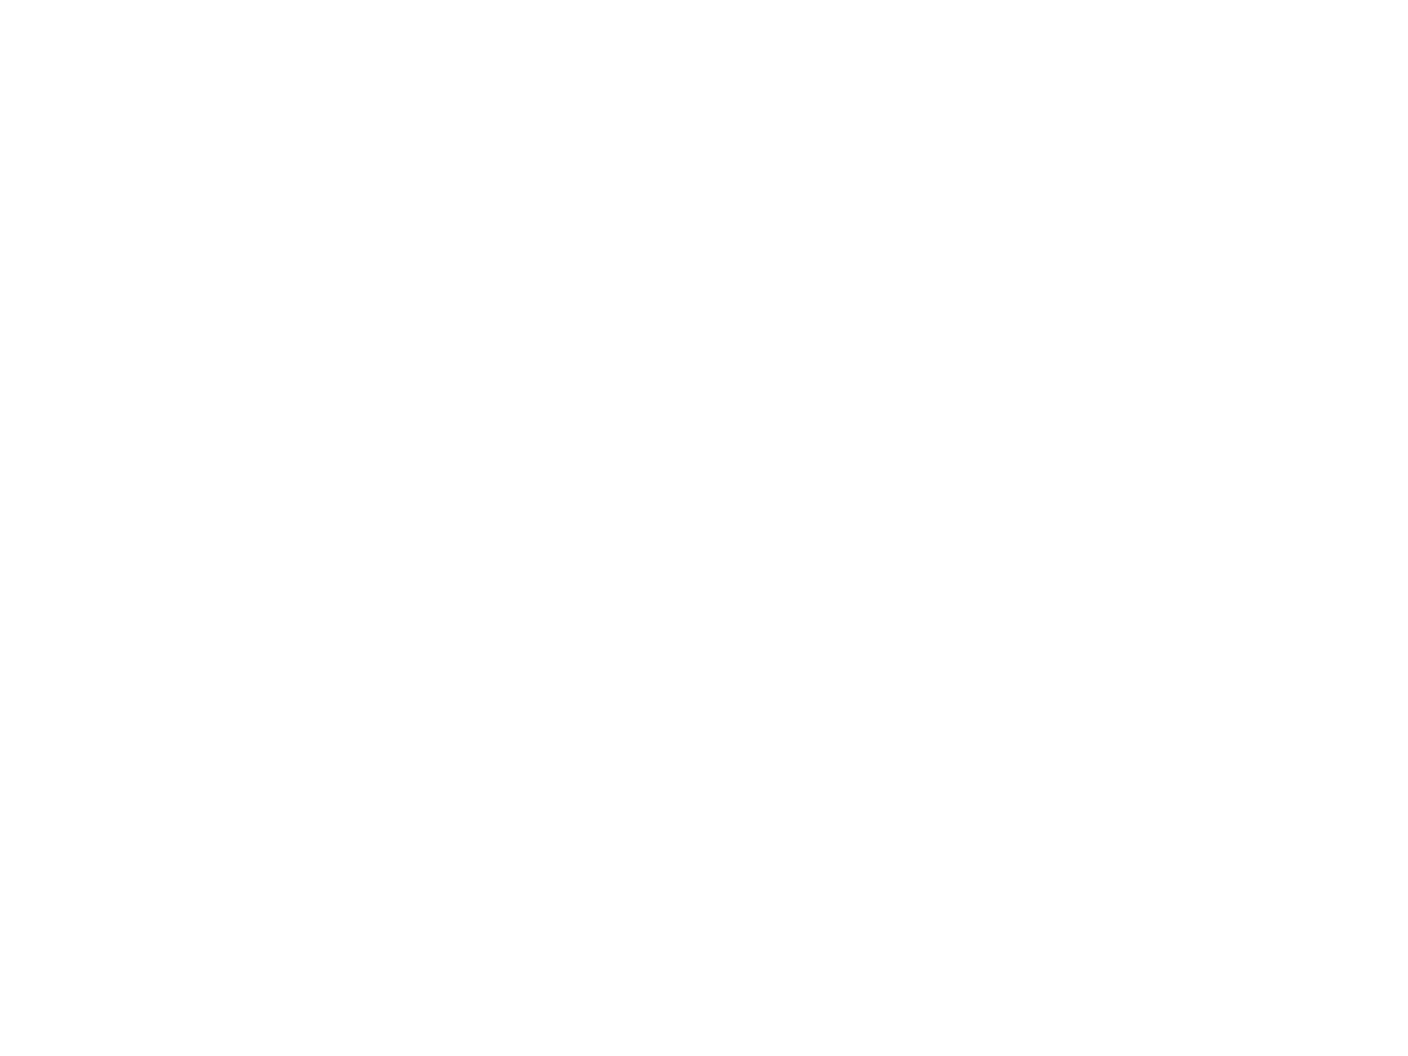

<IPython.core.display.Javascript object>


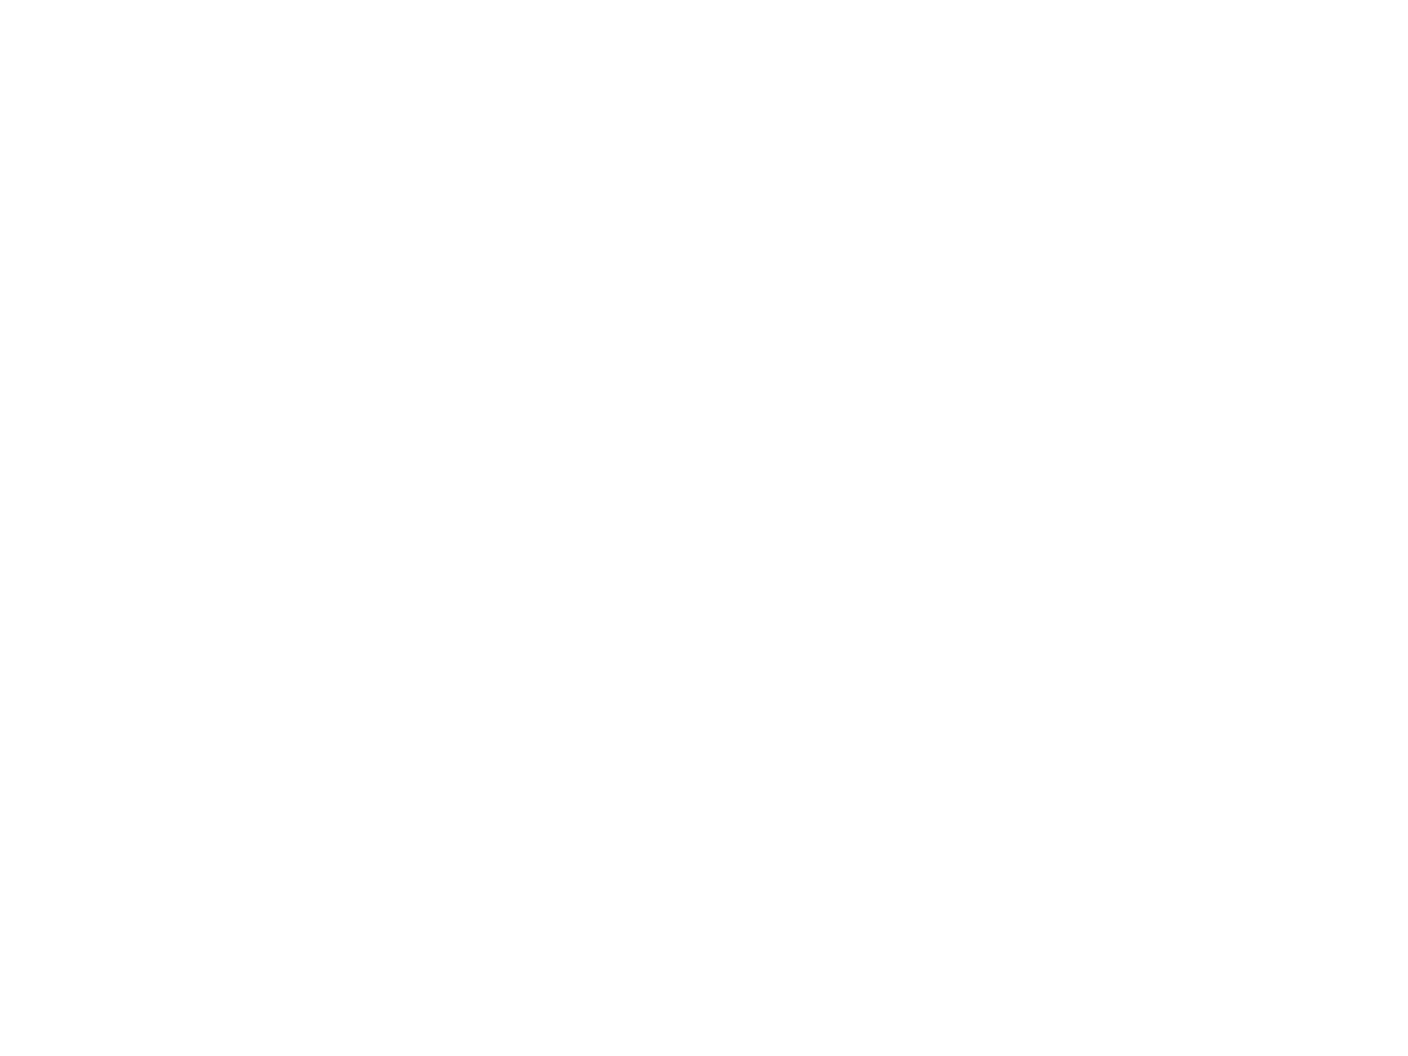

(array([  2.83e-06,   5.12e-06,   1.60e-03,   1.69e-01,   2.91e-05,
          1.86e-05,   1.22e-05,   1.34e-06,   6.90e-07,   4.00e-07,
          3.27e-07,   2.54e-07,   1.82e-07,   1.82e-07,   3.63e-08,
          3.63e-08,   0.00e+00,   0.00e+00,   3.63e-08,   3.63e-08]),
 array([-18.69, -12.84,  -6.99,  -1.14,   4.71,  10.56,  16.41,  22.26,
         28.11,  33.96,  39.81,  45.66,  51.51,  57.36,  63.22,  69.07,
         74.92,  80.77,  86.62,  92.47,  98.32]),
 <a list of 20 Patch objects>)

In [8]:
# FIXME: Complete HoG feature selection
data_open_close = np.asarray(data_dict['open-close'])
x_values = data_open_close[...,0].flatten()
y_values = data_open_close[...,1].flatten()
plt.hist(x_values,bins=20, normed=True)
plt.subplots()
plt.hist(y_values,bins=20, normed=True)
data_empty = np.asarray(data_dict['empty'])
x_values = data_empty[...,0].flatten()
y_values = data_empty[...,1].flatten()
plt.subplots()
plt.hist(x_values,bins=20,normed=True)
plt.subplots()
plt.hist(y_values,bins=20,normed=True)

### Feature optimization

In [9]:
# Load all pre-processed data sets if available.
data_sets = []
DATA_DIR = 'data'

# Number of rows and colums to permute for optical flow feature extraction
divs=[4,10,20]

if os.path.exists(DATA_DIR):
    for file in os.listdir(DATA_DIR):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(DATA_DIR,file))
            df = df.drop('Unnamed: 0',axis=1)
            data_sets.append(df)
else:
    # Generate data sets.
    print("Directory not found at {}\nPreprocessing data for "
        "optimization.".format(os.path.join(os.getcwd(),DATA_DIR)))
    data_sets = make_feature_sets(data_dict,divs=divs)
    save_data_sets(data_sets,divs=divs)

### Feature reduction with integral image

Integral image for fast feature evaluation.

#### Use random forests for comparing feature reduction levels. (Optional)

Confusion matrix, without normalization
[[75  2  2  2]
 [ 4 25  0  4]
 [10  1 14  0]
 [ 4  6  3 18]]


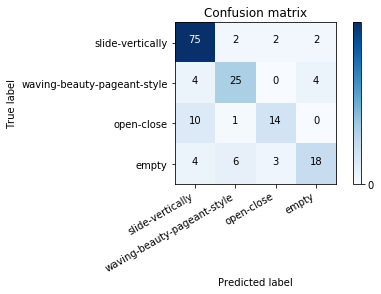

Score for 4x4:
0.7764705882352941
Confusion matrix, without normalization
[[75  3  2  1]
 [ 8 21  1  3]
 [ 8  3 14  0]
 [ 1  6  5 19]]


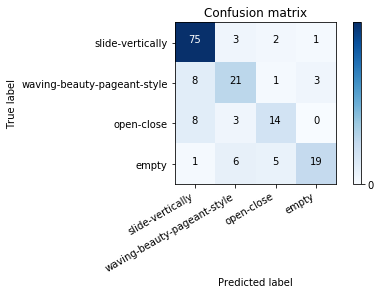

Score for 4x10:
0.7588235294117647
Confusion matrix, without normalization
[[26  4  0 10]
 [ 4 24  0  5]
 [ 3  5 22  4]
 [ 5  3  0 55]]


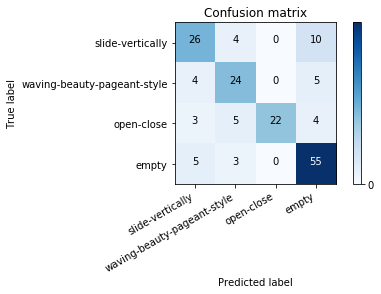

Score for 4x20:
0.7470588235294118
Confusion matrix, without normalization
[[76  2  2  1]
 [ 4 21  4  4]
 [ 9  1 14  1]
 [ 4  4  2 21]]


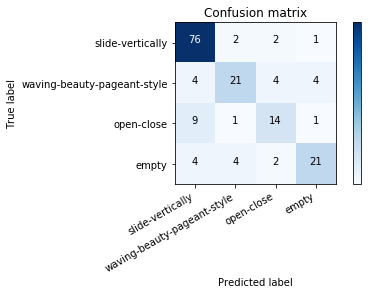

Score for 10x4:
0.7764705882352941
Confusion matrix, without normalization
[[74  2  4  1]
 [ 4 21  4  4]
 [ 9  0 14  2]
 [ 4  5  4 18]]


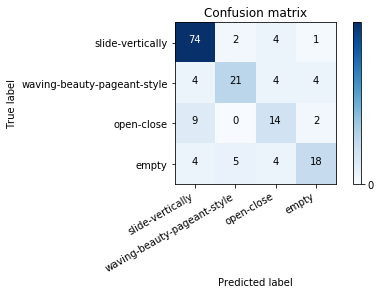

Score for 10x10:
0.7470588235294118
Confusion matrix, without normalization
[[22  3  1 14]
 [ 1 25  0  7]
 [ 2  4 25  3]
 [ 4  2  0 57]]


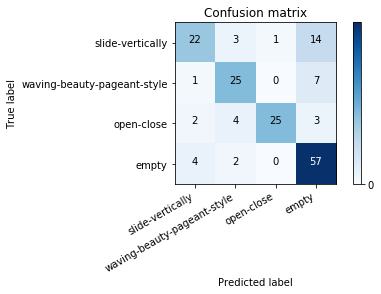

Score for 10x20:
0.7588235294117647
Confusion matrix, without normalization
[[21  4  1 14]
 [ 0 26  0  7]
 [ 4  1 25  4]
 [ 5  0  1 57]]


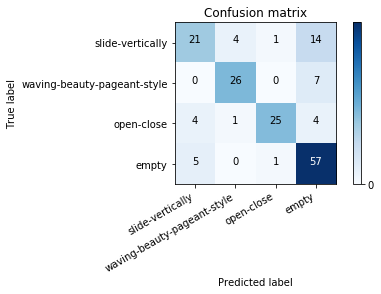

Score for 20x4:
0.7588235294117647
Confusion matrix, without normalization
[[26  2  1 11]
 [ 1 28  0  4]
 [ 5  4 22  3]
 [ 5  1  0 57]]


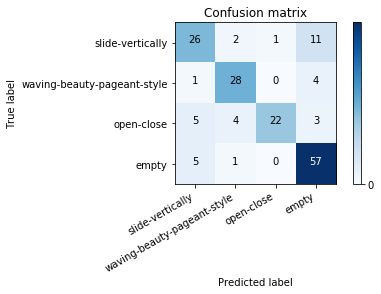

Score for 20x10:
0.7823529411764706
Confusion matrix, without normalization
[[21  6  1 12]
 [ 3 25  0  5]
 [ 3  1 22  8]
 [ 6  1  0 56]]


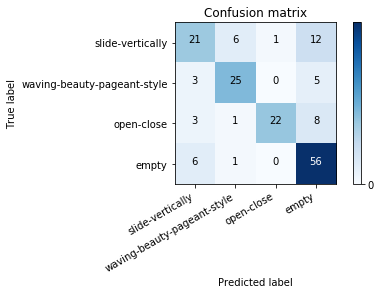

Score for 20x20:
0.7294117647058823


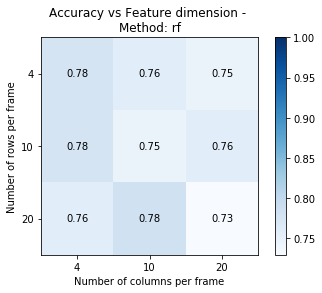

In [10]:
# Example: Reduce the features of one data set.
# Dataframe with 32 (16 * 2 (x and y coordinates)) dimensions
df_red = feature_extract(data_dict,cols=4,rows=4)

# Display comparison of feature reduction levels.
%matplotlib inline
ax = optimize_feature_dimensions(data_sets,divs,method='rf') # also use method='ada'
plt.show()

## Hyper-parameter Optimization with Random Search

Initialize random search module.

In [11]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20

## Perform classification

In [12]:
# Prepare data
data = data_sets[0] # Choose middle (or argmax) feature set
gestures=['open-close','empty','waving-beauty-pageant-style']

# Pandas dataframe `data`
data = data[data['label'].isin(gestures)]
data.head()
data, targets = encode_target(data, 'label') # Encode target column

# Split into features and target
X, Y = class_split(data,gestures=gestures)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

### Multiclass Random Forest Classification

In [13]:
# Classify test data using random forest
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)
accuracy = clf.score(X_test,y_test)

print("Predictions:\n{}".format(clf.predict(X_test)))
print("Actual:\n{}".format(y_test[:10]))
print("Score:\n{}".format(accuracy))

random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

Predictions:
[2 2 1 2 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 2 0 0 0 1 0 0 0 1 0 1 0 0 0 0 2 2 2
 1 0 2 0 1 0 0 1 2 0 0 0 0 0 2 0 0 0 0 0 2 1 2 0 2 1 2 0 2 0 2 1 0 0 0 0 2
 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 1 0 1 0 0 0 2 1 2 0 0 0 0 2 0 2 0 0 0 1 0 0
 1 2 0 1 1 2 1 2 0 1 0 2 0 2 0 1 2 0 0 0 2 1 0 1 2]
Actual:
791    2
739    2
488    1
792    2
456    1
77     0
132    0
76     0
84     0
196    0
Name: Target, dtype: int64
Score:
0.8014705882352942


### Adaboost

In [ ]:
clf_adaboost = AdaBoostClassifier(DecisionTreeClassifier(
        max_depth=3), n_estimators=10)
clf_adaboost = clf_adaboost.fit(X_train, y_train)
accuracy = clf_adaboost.score(X_test, y_test)
print("Predictions:\n{}".format(clf_adaboost.predict(X_test)))
print("Actual:\n{}".format(y_test[:10]))
print("Score:\n{}".format(accuracy))

### Bagging

In [ ]:
clf_bagging = BaggingClassifier()
clf_bagging = clf_bagging.fit(X_train, y_train)
print(clf_bagging.score(X_test, y_test))

### Extra Trees

In [ ]:
clf_extra_tree = ExtraTreesClassifier()
clf_extra_tree = clf_extra_tree.fit(X_train, y_train)
print(clf_extra_tree.score(X_test, y_test))

###  Gradient Boosting

In [ ]:
clf_gradient_boosting = GradientBoostingClassifier()
clf_gradient_boosting = clf_gradient_boosting.fit(X_train, y_train)
print(clf_gradient_boosting.score(X_test,y_test))
# print("Predictions:\n{}".format(clf_bagging.predict(X_test)))
# print("Actual:\n{}".format(y_test))

### Multilayer Perceptron

In [ ]:
clf_mlpc = mlpc()
clf_mlpc = clf_mlpc.fit(X_train, y_train)
print(clf_mlpc.score(X_test,y_test))

### SVM

In [ ]:
clf_svm = svm.SVC(decision_function_shape='ovo')
clf_svm = clf_svm.fit(X_train, y_train)
print(clf_svm.score(X_test,y_test))